# 卷积神经网络

### 卷积操作

/usr/local/lib/python2.7/dist-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/usr/local/lib/python2.7/dist-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


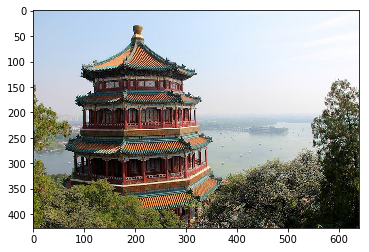

In [1]:
from sklearn.datasets import load_sample_images
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

db =load_sample_images()
img = db.images[0]
plt.imshow(img, cmap="gray", interpolation="nearest")

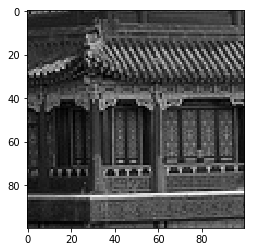

In [3]:
import numpy as np
image = img[150:250, 150:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)
plt.imshow(image_grayscale, cmap="gray")

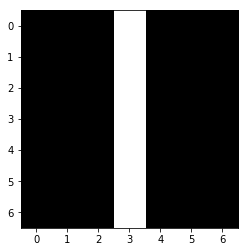

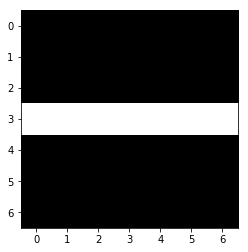

In [10]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plt.imshow(fmap[:, :, 0, 0], cmap="gray")
plt.show()
plt.imshow(fmap[:, :, 0, 1], cmap="gray")
plt.show()

In [12]:
import tensorflow as tf
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

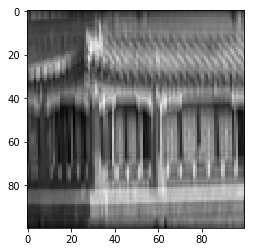

In [14]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})
plt.imshow(output[0, :, :, 0], cmap="gray")

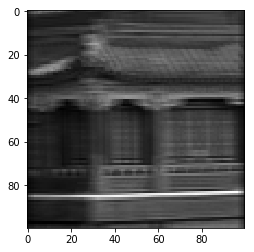

In [17]:
plt.imshow(output[0, :, :, 1], cmap="gray")

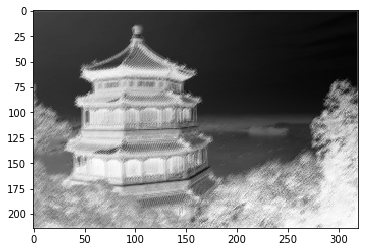

In [18]:
dataset = np.array([img], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})
plt.imshow(output[0, :, :, 1], cmap="gray")

### 池化操作

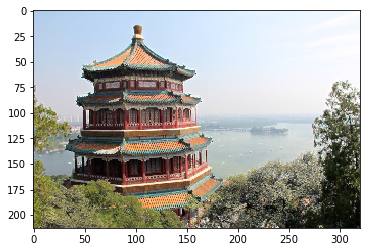

In [19]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

## Tensorflow 卷积神经网络

In [20]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

In [23]:
pool3_fmaps = conv2_fmaps
n_fc1 = 64
n_outputs = 10

In [24]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

In [25]:
with tf.name_scope("conv"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

In [26]:
with tf.name_scope("pool"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

In [27]:
with tf.name_scope("fc"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

In [28]:
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [29]:
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

In [30]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [31]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
n_epochs = 10
batch_size = 100
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images[:batch_size], y: mnist.test.labels[:batch_size]})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

## tf.estimator 卷积神经网络

In [33]:
def cnn_model_fn(features, labels, mode):
      input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
      conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

      pool1 = tf.layers.max_pooling2d(
      inputs=conv1,
      pool_size=[2, 2],
      strides=2)

      conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

      pool2 = tf.layers.max_pooling2d(
      inputs=conv2,
      pool_size=[2, 2],
      strides=2)
          
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
      dense = tf.layers.dense(
      inputs=pool2_flat,
      units=1024,
      activation=tf.nn.relu)
          
      dropout = tf.layers.dropout(
      inputs=dense,
      rate=0.4,
      training = mode == tf.estimator.ModeKeys.TRAIN)
    
      logits = tf.layers.dense(inputs=dropout, units=10)
        
      predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }
      if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())

        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
      eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [34]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./tmp/data/")
train_data = mnist.train.images  # 返回的是 np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # 返回的是 np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

# 创建 Estimator 对象，模型函数使用 cnn_model_fn，模型保存在 model_dir 目录中
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

# 训练模型
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data}, y=train_labels, batch_size=100,
    num_epochs=None, shuffle=True)
mnist_classifier.train( input_fn=train_input_fn, steps=20000)

# 评估模型并打印评估结果
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data}, y=eval_labels, num_epochs=1, shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

Extracting ./tmp/data/train-images-idx3-ubyte.gz
Extracting ./tmp/data/train-labels-idx1-ubyte.gz
Extracting ./tmp/data/t10k-images-idx3-ubyte.gz
Extracting ./tmp/data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f392766f110>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/mnist_convnet_model', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 2.29458, step = 1
INFO:tensorflow:global_step/sec: 0.931069
INFO:tens

KeyboardInterrupt: 

## tf.keras 卷积神经网络

In [35]:
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras.optimizers import Adadelta

In [ ]:
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 将 y_train 和 y_test 转换成 one-hot 编码
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])